In [11]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import utils
import matplotlib

dataPath = './data/'
def prepare_usps_mlfetch():

    import tempfile
    import pickle
    print "importing usps from pickle file ....."

    with open(dataPath+'usps_data.pkl', "rb") as fp:
          loaded_data1 = pickle.load(fp)

    # test_data_home = tempfile.mkdtemp()
    # from sklearn.datasets.mldata import fetch_mldata
    # usps = fetch_mldata('usps', data_home=test_data_home)
    # print usps.target.shape
    # print type(usps.target)
    labels = loaded_data1['target']
    data = loaded_data1['data']
    # print "******",labels

    k_ones = np.where(labels == 2)
    label_ones = labels[k_ones]
    data_ones = data[k_ones]

    k_sevens = np.where(labels == 8)
    label_sevens = labels[k_sevens]
    data_sevens = data[k_sevens]
    #
    # print "data_sevens:",data_sevens.shape
    # print "label_sevens:",label_sevens.shape
    # print "data_ones:",data_ones.shape
    # print "label_ones:",label_ones.shape
    #
    data_ones = data_ones[:220]
    label_ones= label_ones[:220]
    data_sevens = data_sevens[:11]
    label_sevens = label_sevens[:11]

    data = np.concatenate((data_ones,data_sevens),axis=0)
    label = np.concatenate((label_ones,label_sevens),axis=0)
    label[0:220] = 1
    label[220:231] = -1
    # print "1-s",data[0]
    # print label
    # print "7-s",data[230]
    # print label
    # print "data:",data.shape
    # print "label:",label.shape
    return [data,label]

[Xtrue,Xlabels] = prepare_usps_mlfetch()
data = Xtrue

importing usps from pickle file .....


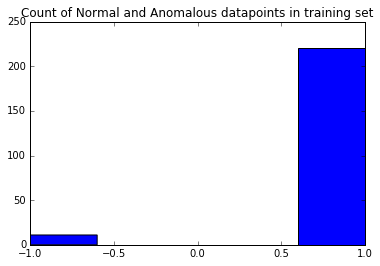

In [12]:
# let's take a look at the types of labels  are present in the data.
# The ones correspond to label 1 and 7's(outliers) correspond to label -1
#data.label.value_counts().plot(kind='bar')  
type(Xlabels)
import matplotlib.pyplot as plt
plt.hist(Xlabels,bins=5)
plt.title("Count of Normal and Anomalous datapoints in training set")
plt.show()

##### MAKING OUR DATA ONE-CLASS

Later we're going to use scikit-learn's OneClassSVM predict function to generate output. This returns +1 or -1 to indicate whether the data is an "inlier" or "outlier" respectively. To make comparison easier later we'll replace our data's label with a matching +1 or -1 value. This also transforms our data from multi-class (multiple different labels) to one-class (boolean label), which is a prerequisite for using a one-class SVM




In [19]:

# series, not a new dataframe
target = Xlabels
# find the proportion of outliers we expect (aka where `labels == -1`). because 
# target is a series, we just compare against itself rather than a column.
outliers = target[target == -1]  
print("outliers.shape", outliers.shape)  
print("outlier fraction", float(outliers.shape[0])/target.shape[0])

# Print the shape of the input data for sanity
print "Training data shape...",data.shape
 

('outliers.shape', (11,))
('outlier fraction', 0.047619047619047616)
Training data shape... (231, 256)


#### SPLITTING DATA INTO TRAINING AND TEST SETS



In [14]:
from sklearn.cross_validation import train_test_split
train_data, test_data, train_target, test_target = train_test_split(data, target, train_size = 0.8)  
train_data.shape  

(184, 256)

#### TRAINING THE MODEL

Now we're ready to train our model. We do this by calling the fit function from scikit-learn's svm.OneClassSVM. It accepts a few parameters but the most important are nu, kernel, and for the RBF kernel we'll be using, gamma.

nu is "An upper bound on the fraction of training errors and a lower bound of the fraction of support vectors" and must be between 0 and 1. Basically this means the proportion of outliers we expect in our data. This is an important factor to consider when assessing algorithms. Many unsupervised ML algorithms require you to know (or hint at) the number of outliers or class members you expect.
kernel is the kernel type to be used. Earlier we discussed SVM's ability to use a non-linear function to project the hyperspace to higher dimension. Setting kernel to something other than linear here will achieve that. The default is rbf (RBF - radial basis function).
gamma is a parameter of the RBF kernel type and controls the influence of individual training samples - this effects the "smoothness" of the model. A low value improves the smoothness and "generalizability" of the model, while a high value reduces it but makes the model "tighter-fitted" to the training data. Some experimentation is often required to find the best value.
We already know that the proportion of attacks in our data is about 4%. We'll get the precise fraction and use that for nu below. Through experimentation I found an effective gamma to be 0.00005.

In our next cell we'll instantiate a model and fit (train) it with our training data.



In [15]:
from sklearn import svm

# set nu (which should be the proportion of outliers in our dataset)
nu = float(outliers.shape[0]) / target.shape[0]  
print("nu", nu)

model = svm.OneClassSVM(nu=nu, kernel='rbf', gamma=0.00005)  
model.fit(train_data)

('nu', 0.047619047619047616)


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=5e-05, kernel='rbf',
      max_iter=-1, nu=0.047619047619, random_state=None, shrinking=True,
      tol=0.001, verbose=False)

#### CHECKING ACCURACY OF THE MODEL

In [16]:
from sklearn import metrics  
preds = model.predict(train_data)  
targs = train_target
print ("====== Training Dataset Accuracy=======================")
print("Training Dataset accuracy: ", metrics.accuracy_score(targs, preds))  
print("Training Dataset precision: ", metrics.precision_score(targs, preds))  
print("Training Dataset recall: ", metrics.recall_score(targs, preds))  
print("Training Dataset f1: ", metrics.f1_score(targs, preds))  
print("Training Dataset area under curve (auc): ", metrics.roc_auc_score(targs, preds))  
print ("====== Test Dataset Accuracy=======================")

preds = model.predict(test_data)  
targs = test_target

print("Test Dataset accuracy: ", metrics.accuracy_score(targs, preds))  
print("Test Dataset precision: ", metrics.precision_score(targs, preds))  
print("Test Dataset recall: ", metrics.recall_score(targs, preds))  
print("Test Dataset f1: ", metrics.f1_score(targs, preds))  
print("Test Dataset area under curve (auc): ", metrics.roc_auc_score(targs, preds))  

====== Training Dataset Accuracy=======================
('Training Dataset accuracy: ', 0.95652173913043481)
('Training Dataset precision: ', 0.98843930635838151)
('Training Dataset recall: ', 0.96610169491525422)
('Training Dataset f1: ', 0.97714285714285709)
('Training Dataset area under curve (auc): ', 0.84019370460048426)
====== Test Dataset Accuracy=======================
('Test Dataset accuracy: ', 0.91489361702127658)
('Test Dataset precision: ', 0.97560975609756095)
('Test Dataset recall: ', 0.93023255813953487)
('Test Dataset f1: ', 0.95238095238095244)
('Test Dataset area under curve (auc): ', 0.84011627906976738)
